# PROSPECT model

This notebook is for testing the Disney & Lewis PROSPECT model on the ANGERS and LOPEX datasets

In [1]:
%matplotlib notebook

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# from prospy.load_data import *
# from prospy.prospect import *
# from prospy.parameters import *
# from prospy.prosfuncs import *
# from prospy.inversionfuncs import *
# from prospy.datatools import load_leafspectra


from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import curve_fit


import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())

#import spectralinvariant as si
from spectralinvariant.prospect import *#prospect_wavelengths
from spectralinvariant.spectralinvariants import leafalbedo_LD, lsq
wl_prospect = prospect_wavelengths()

# import pymc3 as pm
# import arviz as az
# print(f"Running on PyMC3 v{pm.__version__}")


In [2]:
def generate_spectra_LD(wl, Cab=48.6, Cw=0.0115, Cm=0.0045, Car=10.5, *args, **kwargs):
    """Generates leaf reflectance and transmittance using a given PROSPECT model
    """
    LRT = leafalbedo_LD(Cab, Cw, Cm, *args, **kwargs)
    LRT = np.interp(wl, wl_prospect, LRT)
    return LRT

def generate_spectra_Cp(wl, Cab=48.6, Cw=0.0115, Cm=0.0045, Car=10.5, N=2, *args, **kwargs):
    """Generates leaf reflectance and transmittance using a given PROSPECT model
    """
    LRT = prospect_Cp(N, Cab, Cw, Cm, *args, **kwargs)
    W = LRT[:,0]
    R = LRT[:,1]
    T = LRT[:,2]
    R = np.interp(wl, W, R)
    T = np.interp(wl, W, T)
    return R, T

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
def load_spectra(fpath, df, idx, dname='angers'):
    if dname == 'angers':
        s = 'an03'
    elif dname == 'lopex':
        s = 'lo93'
    else:
        raise Exception('The data name has to be either angers or lopex.')

    file_idx = df['Refl_file'][idx]
    if file_idx < 10:
        fname_r = '{}r000{}.txt'.format(s, file_idx)
        fname_t = '{}t000{}.txt'.format(s, file_idx)
    elif file_idx >= 10 and file_idx < 100:
        fname_r = '{}r00{}.txt'.format(s, file_idx)
        fname_t = '{}t00{}.txt'.format(s, file_idx)

    if file_idx >= 100:
        fname_r = '{}r0{}.txt'.format(s, file_idx)
        fname_t = '{}t0{}.txt'.format(s, file_idx)

    r = np.loadtxt(fpath / fname_r)
    wavelength = r[:,0]
    reflectance = r[:,1]
    t = np.loadtxt(fpath / fname_t)
    transmittance = t[:,1]
    return wavelength, reflectance, transmittance


def get_leaf_params(df, idx):

    N = df['N'][idx]
    C_a = df['C_a'][idx]
    C_b = df['C_b'][idx]
    C_ab = df['C_ab'][idx]
    C_car = df['C_car'][idx]
    C_w = df['EWT'][idx]
    C_m = df['LMA'][idx]
    
    return N, C_a, C_b, C_ab, C_car, C_w, C_m

In [4]:
fpath_angers = Path('E:\REFORMERS\Datafiles\Angers2003')
fname_angers = fpath_angers / 'LDB_angers2003.xls'

fpath_lopex = Path('E:\REFORMERS\Datafiles\LOPEX1993')
fname_lopex = fpath_lopex / 'LDB_lopex1993.xls'

df_angers = pd.read_excel(fname_angers, sheet_name='Database')
indices_angers = df_angers.index.values

df_lopex = pd.read_excel(fname_lopex, sheet_name='Database')
indices_lopex = df_lopex.index.values

df_angers.head()

,English Name,Latin Name,Refl_file,Trans_file,Plant Type,N,C_a,C_b,C_ab,C_car,C_anth,EWT,LMA,SPAD,T660,T720,T840,T940,T1300
0,Sycamore maple,Acer pseudoplatanus L.,1,1,2,1.313594,9.526932,3.013850,12.540782,4.33,-999,0.012223,0.005507,18.6375,0.082063,0.233124,0.342019,0.340148,0.258489
1,Sycamore maple,Acer pseudoplatanus L.,2,2,2,1.425785,9.005425,3.408264,12.413689,3.65,-999,0.012000,0.005252,19.1500,0.090501,0.247603,0.352357,0.347906,0.267809
2,Sycamore maple,Acer pseudoplatanus L.,3,3,2,1.549407,19.363700,6.450325,25.814022,6.50,-999,0.010600,0.004456,30.8125,0.051558,0.274483,0.420927,0.423752,0.336191
3,Sycamore maple,Acer pseudoplatanus L.,4,4,2,1.652313,18.663168,5.471817,24.134988,6.90,-999,0.010854,0.004329,30.4625,0.044840,0.222036,0.369032,0.364431,0.277155
4,Sycamore maple,Acer pseudoplatanus L.,5,5,2,1.437254,12.157069,4.964505,17.121578,4.91,-999,0.010377,0.004011,21.8750,0.070874,0.241489,0.335033,0.340661,0.258644


In [5]:
df_lopex.head()

,English Name,Latin Name,Refl_file,Trans_file,Plant Type,N,C_a,C_b,C_ab,C_car,...,C_O,C_N,C_prot1,C_prot2,C_cell1,C_cell2,C_lign1,C_lign2,C_star1,C_star2
0,Red clover,Trifolium pratense L.,1,1,2,1.696103,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
1,NaN,NaN,2,2,2,1.635764,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
2,NaN,NaN,3,3,2,1.600121,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
3,NaN,NaN,4,4,2,2.194581,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
4,NaN,NaN,5,5,2,1.893365,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43


In [6]:

def select_wls(wl, r, t, wl_a=500, wl_b=600):
    b_a = find_nearest(wl, wl_a)
    b_b = find_nearest(wl, wl_b)
    wl = wl[b_a:b_b]
    r = r[b_a:b_b]
    t = t[b_a:b_b]
    return wl, r, t


def err_cab(cab, wl, x, kwargs):
    albedo = leafalbedo_LD(Cab=cab, **kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)
    
    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
    err = pred - x
    return err.dot(err)


def err_cab_nop(cab, wl, x, kwargs):
    albedo = leafalbedo_LD(Cab=cab, **kwargs)
    pred = np.interp(wl, wl_prospect, albedo)
    
    err = pred - x
    return err.dot(err)


def err_car(car, wl, x, kwargs):
    albedo = leafalbedo_LD(Car=car, **kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)
    
    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
    err = pred - x
    return err.dot(err)


def err_cab_car(var, wl, x, kwargs):
    cab, car = var
    albedo = leafalbedo_LD(Cab=cab, Car=car, **kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)
    
    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
    err = pred - x
    return err.dot(err)



In [7]:
def fn_cab(wl, r, t, wl_a, wl_b, kwargs, bounds=[(0.1, 200)]):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
    a = r + t
    ans = minimize(err_cab, x0=[30], args=(wl, a, kwargs), bounds=bounds)
    return ans

def fn_car(wl, r, t, wl_a, wl_b, kwargs, bounds=[(0.1, 200)]):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
    a = r + t
    ans = minimize(err_car, x0=[10], args=(wl, a, kwargs), bounds=bounds)
    return ans

In [8]:
idx = 46
wavelengths, r_lopex, t_lopex = load_spectra(fpath_lopex, df_lopex, idx, dname='lopex')

N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_lopex, idx)

In [9]:
# CAB INVERSION
#wl_a, wl_b = (520, 600)
wl_a, wl_b = (480, 600)
print(Cab, Cw, Cm, Car)
cab_kwargs = {'Cw': Cw, 'Cm': Cm, 'Car': Car}
ans_cab = fn_cab(wavelengths, r_lopex, t_lopex, wl_a, wl_b, cab_kwargs)
print(ans_cab.x[0])
print(Cab, Car)

35.82673170731707 0.016073170731707314 0.002780487804878049 5.486048780487805
22.153084234068867
35.82673170731707 5.486048780487805


In [10]:
indices_lopex

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [11]:
cabs = np.zeros(len(indices_lopex))
Cabs = np.zeros(len(indices_lopex))
cars = np.zeros(len(indices_lopex))
Cars = np.zeros(len(indices_lopex))

Ptype = []
wl_a, wl_b = (480, 600)

for idx in indices_lopex:
    wavelengths, r_lopex, t_lopex = load_spectra(fpath_lopex, df_lopex, idx, dname='lopex')

    N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_lopex, idx)
    cab_kwargs = {'Cw': Cw, 'Cm': Cm, 'Car': Car}
    ans_cab = fn_cab(wavelengths, r_lopex, t_lopex, wl_a, wl_b, cab_kwargs)

    cab = ans_cab.x[0]
    Cabs[idx] = Cab
    cabs[idx] = cab
    Ptype.append(df_lopex['English Name'][idx])
#     Cars[index] = Car
#     cars[index] = car
    #print(cab, Cab)
#     L, R, T = prosfn(N, Cab, Cw, Cm, Car).T
#     A = leafalbedo_LD(Cab, Cw, Cm, Car)
#     R =  np.interp(wl, L, R)
#     T =  np.interp(wl, L, T)
#     A = np.interp(wl, L, A)

    #A_LD = invert_cab_LD(np.array([wl, a]), cab)

    

In [12]:
bad = np.where(abs(cabs - 60) < 1) and np.where(np.abs(cabs - Cabs) > 5)[0]
good = np.where(abs(cabs - 60) > 1) and np.where(np.abs(cabs - Cabs) < 10)[0]
good = np.where(Cabs>0)[0]

#cabs#[cabs>40]

<IPython.core.display.Javascript object>


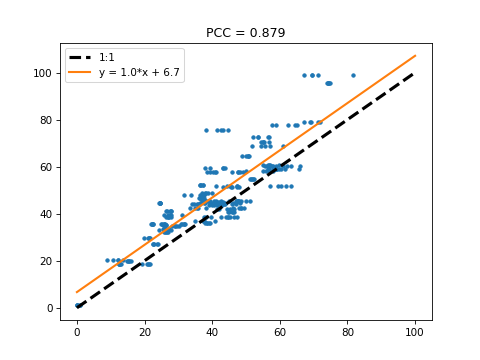

In [13]:
#lrg = linregress(cabs, Cabs)
lrg = linregress(cabs[good], Cabs[good])
xx = np.linspace(0,100, 100)
yy = xx*lrg.slope + lrg.intercept


plt.figure()
plt.title(f'PCC = {lrg.rvalue:.3f}')
plt.scatter(cabs[good], Cabs[good], s=10)
#plt.scatter(cabs, Cabs, s=10)
plt.plot([0,100], [0,100], c='k', linewidth=3, linestyle='--', label='1:1')
plt.plot(xx, yy, c='tab:orange', linewidth=2, label=f'y = {lrg.slope:.1f}*x + {lrg.intercept:.1f}')
plt.legend()

# ANGERS

In [14]:
cabs = np.zeros(len(indices_angers))
Cabs = np.zeros(len(indices_angers))
cars = np.zeros(len(indices_angers))
Cars = np.zeros(len(indices_angers))

wl_a, wl_b = (480, 600)

for idx in indices_angers[0:9]:
    wavelengths, r, t = load_spectra(fpath_angers, df_angers, idx, dname='angers')

    N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_angers, idx)
    cab_kwargs = {'Cw': Cw, 'Cm': Cm, 'Car': Car}
    ans_cab = fn_cab(wavelengths, r, t, wl_a, wl_b, cab_kwargs)

    cab = ans_cab.x[0]
    Cabs[idx] = Cab
    cabs[idx] = cab
#     Cars[index] = Car
#     cars[index] = car
    #print(cab, Cab)
#     L, R, T = prosfn(N, Cab, Cw, Cm, Car).T
#     A = leafalbedo_LD(Cab, Cw, Cm, Car)
#     R =  np.interp(wl, L, R)
#     T =  np.interp(wl, L, T)
#     A = np.interp(wl, L, A)

    #A_LD = invert_cab_LD(np.array([wl, a]), cab)

    

In [15]:
bad = np.where(abs(cabs - 60) < 1) and np.where(np.abs(cabs - Cabs) > 5)[0]
good = np.where(abs(cabs - 60) > 1) and np.where(np.abs(cabs - Cabs) < 10)[0]

#cabs#[cabs>40]

<IPython.core.display.Javascript object>


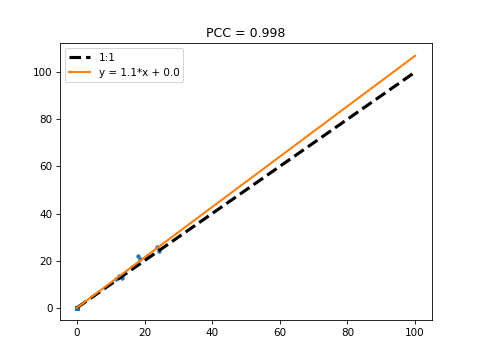

In [16]:
lrg = linregress(cabs, Cabs)
# lrg = linregress(cabs[good], Cabs[good])
xx = np.linspace(0,100, 100)
yy = xx*lrg.slope + lrg.intercept


plt.figure()
plt.title(f'PCC = {lrg.rvalue:.3f}')
# plt.scatter(cabs[good], Cabs[good], s=10)
plt.scatter(cabs, Cabs, s=10)
plt.plot([0,100], [0,100], c='k', linewidth=3, linestyle='--', label='1:1')
plt.plot(xx, yy, c='tab:orange', linewidth=2, label=f'y = {lrg.slope:.1f}*x + {lrg.intercept:.1f}')
plt.legend()

In [17]:
def spectra_cab(cab, wl, x, kwargs):
    albedo = leafalbedo_LD(Cab=cab, **kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)
    
    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
    return pred

def select_wls2(wl, albedo, wl_a=500, wl_b=600):
    b_a = find_nearest(wl, wl_a)
    b_b = find_nearest(wl, wl_b)
    wl = wl[b_a:b_b]
    albedo = albedo[b_a:b_b]
    return wl, albedo

In [18]:
spectra_cab(cab, np.arange(480, 600), select_wls2(wavelengths, r+t, 480, 600)[1], cab_kwargs)

array([0.08146466, 0.08209948, 0.08285417, 0.08367824, 0.08467938,
       0.08583111, 0.08714933, 0.08865919, 0.09038541, 0.09235651,
       0.0944722 , 0.09678143, 0.0993089 , 0.1020892 , 0.10506495,
       0.10830096, 0.11181237, 0.1156186 , 0.11974161, 0.12414289,
       0.12890364, 0.13398573, 0.13937821, 0.14514237, 0.15124827,
       0.15769635, 0.16453001, 0.17172753, 0.17926999, 0.18713457,
       0.19534212, 0.20391112, 0.21279941, 0.22196888, 0.2313877 ,
       0.24095671, 0.25063582, 0.26036966, 0.27007501, 0.27970759,
       0.28919353, 0.29849863, 0.30756526, 0.31631844, 0.32464127,
       0.33254335, 0.33996919, 0.34688586, 0.35326344, 0.35914162,
       0.36454287, 0.36947136, 0.37393314, 0.37791333, 0.38148525,
       0.38466288, 0.38747261, 0.38993604, 0.39215753, 0.39409176,
       0.39581569, 0.39736152, 0.3987456 , 0.40006054, 0.40130561,
       0.40250675, 0.40366277, 0.40475233, 0.4057471 , 0.40659978,
       0.40730518, 0.40778782, 0.40807193, 0.4080027 , 0.40766

In [19]:
cab, Cab

(20.610987006809392, 21.874468)

<IPython.core.display.Javascript object>


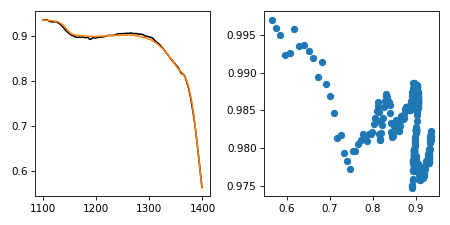

In [20]:
wl_a, wl_b = (1100, 1400)
#wl = np.arange(wl_a, wl_b)
wl, rr = select_wls2(wavelengths, r+t, wl_a, wl_b)
scab = spectra_cab(cab, wl, select_wls2(wavelengths, r+t, wl_a, wl_b)[1], cab_kwargs)
acab = leafalbedo_LD(Cab=cab, **cab_kwargs)
acab = np.interp(wl, wl_prospect, acab)

fig = plt.figure(figsize=(6,3), tight_layout=True)
ax = fig.add_subplot(121)
ax.plot(wl, rr, c='k')
ax.plot(wl, scab, c='tab:orange')

ax = fig.add_subplot(122)
ax.scatter(rr, rr/acab)


In [21]:
# # CAB INVERSION
# #wl_a, wl_b = (520, 600)
# wl_a, wl_b = (480, 600)
# print(Cab, Cw, Cm, Car)
# cab_kwargs = {'Cw': Cw, 'Cm': Cm, 'Car': Car}
# ans_cab = fn_cab(wavelengths, r, t, wl_a, wl_b, cab_kwargs)
# cab = ans_cab.x[0]
# print(ans_cab.x[0])
# print(Cab, Car)

# Dry matter and water content

In [22]:
def err_cm(cm, wl, x, kwargs):
    albedo = leafalbedo_LD(Cm=cm, **kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)
    
    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
    err = pred - x
    return err.dot(err)


def fn_cm(wl, r, t, wl_a, wl_b, kwargs, bounds=[(0.00, 0.02)]):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
    a = 2*r#r + t
    ans = minimize(err_cm, x0=[0.009], args=(wl, a, kwargs), bounds=bounds)
    return ans


def err_cw(cw, wl, x, kwargs):
    albedo = leafalbedo_LD(Cw=cw, **kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)
    
    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
    err = pred - x
    return err.dot(err)


def fn_cw(wl, r, t, wl_a, wl_b, kwargs, bounds=[(0.00, 0.1)]):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
    a = 2*r#r + t
    ans = minimize(err_cw, x0=[0.0001], args=(wl, a, kwargs), bounds=bounds)
    return ans

In [24]:
u = Cw
kwargs = {'Cm': Cm, 'Cab': Cab, 'Car': Car, 'unknown': 'Cw'}
# print(kwargs)
kwargs[kwargs['unknown']] = u
kwargs.pop('unknown')
kwargs

{'Cm': 0.0041699, 'Cab': 21.874468, 'Car': 5.68, 'Cw': 0.00967662}

In [369]:
def generate_spectra_Cp(wl, Cab=48.6, Cw=0.0115, Cm=0.0045, Car=10.5, N=2, *args, **kwargs):
    """Generates leaf reflectance and transmittance using a given PROSPECT model
    """
    LRT = prospect_Cp(N, Cab, Cw, Cm, *args, **kwargs)
    W = LRT[:,0]
    R = LRT[:,1]
    T = LRT[:,2]
    R = np.interp(wl, W, R)
    T = np.interp(wl, W, T)
    return R+T#2*R#, T

def select_wls(wl, r, t, wl_a=500, wl_b=600):
    b_a = find_nearest(wl, wl_a)
    b_b = find_nearest(wl, wl_b)
    wl = wl[b_a:b_b]
    r = r[b_a:b_b]
    t = t[b_a:b_b]
    return wl, r, t


def pred_fn(u, wl, x, params):
    params[params['unknown']] = u
    kwargs = params.copy()
    kwargs.pop('unknown')

#     LRT = prospect_Cp(**kwargs)
#     R = LRT[:,1]
#     T = LRT[:,2]
#     R = np.interp(wl, wl_prospect, R)
#     T = np.interp(wl, wl_prospect, T)
#     albedo = R + T
    
    albedo = leafalbedo_LD(**kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)

#     albedo = generate_spectra_Cp(wl, **kwargs)
#     albedo = generate_spectra_LD(wl, **kwargs)

    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
#     pred = albedo
    return pred


def err_fn(u, wl, x, params):
    pred = pred_fn(u, wl, x, params)
    err = pred - x
    return err.dot(err)


def buffer_fn(r, t, wl, wl_a, wl_b, params, bounds=[(0.00, 0.02)]):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
#     x = 2*r#r + t
    x = r + t
    pred = pred_fn(Cw, wl, x, params)
    return pred


def minimize_fn(r, t, wl, wl_a, wl_b, params, bounds=[(0.00, 0.02)], x0=0.0001):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
#     x = 2*r#r + t
    x = r + t
    ans = minimize(err_fn, x0=[x0], args=(wl, x, params), bounds=bounds)
    return ans



In [370]:
def pred_ac(true, model):
    n = len(true)
    err = model - true
    mse = err.dot(err) / n
    rmse = np.sqrt(mse)
    
    bias = np.sum(err) / n
    sepc = np.dot(err - bias, err - bias) / n
    sepc = np.sqrt(sepc)
    cv = 100. * sepc / np.mean(true)
    return rmse, bias, sepc, cv
    

In [371]:
idx = 21
wavelengths, r, t = load_spectra(fpath_angers, df_angers, idx, dname='angers')

N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_angers, idx)
print(Cab, Cw, Cm, Car)


14.109113 0.01117268 0.00455185 3.75


In [372]:
# u = 'Cw'
# params = {'Cm': Cm, 'Cab': Cab, 'Car': Car, 'unknown': u}
u = 'Cw'
d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}
params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car, 'unknown': u, 'Cm': Cm}
params.pop(u)


wl_a, wl_b = (1520, 1600)
# wl_a, wl_b = (1400, 1600)
bounds=[(0.00, 0.1)]
x0 = 0.0001

ans_cw = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=x0)

ans_cw.x, Cm

(array([0.01058413]), 0.00455185)

In [373]:
# u = 'Cw'
# params = {'Cm': Cm, 'Cab': Cab, 'Car': Car, 'unknown': u}
u = 'Cab'
d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}
params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car, 'unknown': u, 'Cm': Cm}
params.pop(u)

wl_a, wl_b = (400, 600)
bounds=[(0.00, 100)]
x0 = 40.0001

ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=x0)

ans.x, Cab

(array([12.20369264]), 14.109113)

In [374]:
u = 'N'
d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}
params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car, 'unknown': u, 'Cm': Cm}
params.pop(u)

wl_a, wl_b = (1600, 1700)
bounds=[(1.01, 20)]
x0 = 2.0001

ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=x0)

ans.x, d[u]

(array([2.0001]), 1.439834412)

In [386]:
dname = 'lopex'
if dname == 'lopex':
    df = df_lopex
    fpath = fpath_lopex
    indices = indices_lopex
    
elif dname == 'angers':
    df = df_angers
    fpath = fpath_angers
    indices = indices_angers
else:
    raise Exception('dname must be either lopex or angers')

In [390]:
model = np.zeros(len(indices))
true = np.zeros(len(indices))

# wl_a, wl_b = (1600, 1800)
wl_a, wl_b = (480, 590)
# wl_a, wl_b = (1520, 1650)
# wl_a , wl_b = (1000, 1600)
# u = 'Cw'
# u = 'Cm'
# u = 'Cab'
u = 'Car'
bounds=[(0.00, 110.05)]
x0 = 10.0001


for idx in indices:
    wavelengths, r, t = load_spectra(fpath, df, idx, dname=dname)
    N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df, idx)
    d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}
    params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car, 'unknown': u, 'Cm': Cm}
    params.pop(u)
#     print(params)
    
    ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=x0)

    est = ans.x[0]
    true[idx] = d[u]
    model[idx] = est


<IPython.core.display.Javascript object>


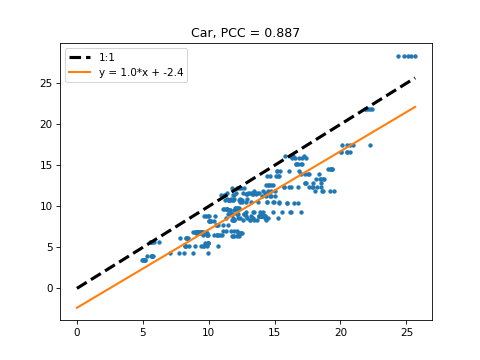

In [391]:
good = np.where(true!=-999)
model = model[good]
true = true[good]

lrg = linregress(model, true)
xx = np.linspace(0, model.max(), 100)
yy = xx*lrg.slope + lrg.intercept


plt.figure()
plt.title(f'{u}, PCC = {lrg.rvalue:.3f}')

plt.scatter(model, true, s=10)
plt.plot([0, model.max()], [0, model.max()], c='k', linewidth=3, linestyle='--', label='1:1')
plt.plot(xx, yy, c='tab:orange', linewidth=2, label=f'y = {lrg.slope:.1f}*x + {lrg.intercept:.1f}')
plt.legend()

In [392]:
rmse, bias, sepc, cv = pred_ac(true, model)

print(f'RMSEP = {rmse:.4f}, BIAS = {bias:.5f}, SEPC = {sepc:.4f}, CV = {cv:.2f} %')



RMSEP = 3.5573, BIAS = 2.97302, SEPC = 1.9533, CV = 18.95 %


In [279]:
rmse, bias, sepc, cv = pred_ac(true, model)

print(f'RMSEP = {rmse:.4f}, BIAS = {bias:.5f}, SEPC = {sepc:.4f}, CV = {cv:.2f} %')


RMSEP = 0.0016, BIAS = -0.00019, SEPC = 0.0016, CV = 13.53 %


In [260]:
mse = np.dot(model - true, model - true) / len(true)
rmse = np.sqrt(mse)# / np.mean(Cws)
mae = np.sum(np.abs(model - true)) / len(true)
print(f'RMSE = {rmse:.4f}, MAE = {mae:.4f}')
print(f'True mean = {np.mean(true):.4f}, estimated mean = {np.mean(model):.4f}')
pred_ac(true, model)


RMSE = 0.0034, MAE = 0.0028
True mean = 0.0116, estimated mean = 0.0091


(0.00344491690178366,
 -0.002492076726722281,
 0.002378446141564676,
 20.46921343159713)

In [134]:
print(wl_a, wl_b, lrg.rvalue)
pred_ac(true, model)


450 600 0.9496691941733327


(2.0980986975316154, 1.3319816063637022, 1.6210623507109874, 18.71450179636481)

In [379]:
#wl_a, wl_b = (1100, 1400)#
wl_a, wl_b = (1520, 1600)
cw_kwargs = {'Cm': Cm, 'Cab': Cab, 'Car': Car}
ans_cw = fn_cw(wavelengths, r, t, wl_a, wl_b, cw_kwargs)

ans_cw.x, Cw

(array([0.00832862]), 0.007865168539325843)

In [31]:
wl_a, wl_b = (1600, 1800)
cm_kwargs = {'Cw': Cw, 'Cab': Cab, 'Car': Car}
ans_cm = fn_cm(wavelengths, r_angers, t_angers, wl_a, wl_b, cm_kwargs)

ans_cm.x, Cm

(array([0.00313543]), 0.00264195)

In [384]:
cws = np.zeros(len(indices_lopex))
Cws = np.zeros(len(indices_lopex))
# cars = np.zeros(len(indices_lopex))
# Cars = np.zeros(len(indices_lopex))

wl_a, wl_b = (1550, 1650)

for idx in indices_lopex:
# for idx in indices_angers:
    wavelengths, r_lopex, t_lopex = load_spectra(fpath_lopex, df_lopex, idx, dname='lopex')
    N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_lopex, idx)
#     wavelengths, r_lopex, t_lopex = load_spectra(fpath_angers, df_angers, idx, dname='angers')
#     N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_angers, idx)
    cw_kwargs = {'Cm': Cm, 'Cab': Cab, 'Car': Car}
    ans_cw = fn_cw(wavelengths, r_lopex, t_lopex, wl_a, wl_b, cw_kwargs)

    cw = ans_cw.x[0]
    Cws[idx] = Cw
    cws[idx] = cw


<IPython.core.display.Javascript object>


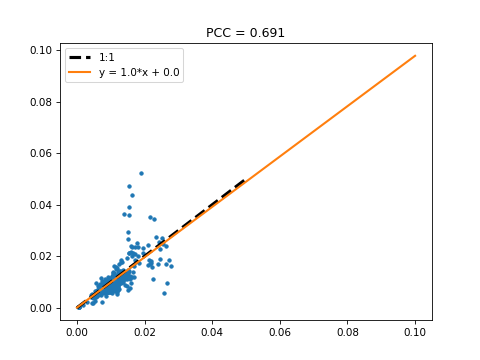

In [385]:
#bad = np.where(abs(cws - 60) < 1) and np.where(np.abs(cws - cws) > 5)[0]
#good = np.where(abs(cws - 60) > 1) and np.where(np.abs(cws - Cws) < 10)[0]
#good = np.where(cws<0.09)
#cabs#[cabs>40]

# lrg = linregress(cws, Cws)
lrg = linregress(cws[good], Cws[good])
xx = np.linspace(0,0.1, 100)
yy = xx*lrg.slope + lrg.intercept


plt.figure()
plt.title(f'PCC = {lrg.rvalue:.3f}')
plt.scatter(cws[good], Cws[good], s=10)
# plt.scatter(cws, Cws, s=10)
plt.plot([0,0.05], [0, 0.05], c='k', linewidth=3, linestyle='--', label='1:1')
plt.plot(xx, yy, c='tab:orange', linewidth=2, label=f'y = {lrg.slope:.1f}*x + {lrg.intercept:.1f}')
plt.legend()

In [386]:
mse = np.dot(cws - Cws, cws - Cws) / len(Cws)
rmse = np.sqrt(mse)# / np.mean(Cws)
mae = np.sum(np.abs(cws - Cws)) / len(Cws)
print(f'RMSE = {rmse:.4f}, MAE = {mae:.4f}')
print(f'True mean = {np.mean(Cws):.4f}, estimated mean = {np.mean(cws):.4f}')

RMSE = 0.0050, MAE = 0.0028
True mean = 0.0111, estimated mean = 0.0113


In [36]:
cws = np.zeros(len(indices_lopex))
Cws = np.zeros(len(indices_lopex))
# cars = np.zeros(len(indices_lopex))
# Cars = np.zeros(len(indices_lopex))

wl_a, wl_b = (1600, 1800)

#for idx in indices_lopex:
for idx in indices_angers:
#     wavelengths, r_lopex, t_lopex = load_spectra(fpath_lopex, df_lopex, idx, dname='lopex')
#     N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_lopex, idx)
    wavelengths, r_lopex, t_lopex = load_spectra(fpath_angers, df_angers, idx, dname='angers')
    N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df_angers, idx)
    
    cw_kwargs = {'Cw': Cw, 'Cab': Cab, 'Car': Car}
    ans_cw = fn_cm(wavelengths, r_lopex, t_lopex, wl_a, wl_b, cw_kwargs)

    cw = ans_cw.x[0]
    Cws[idx] = Cm
    cws[idx] = cw


In [37]:
mse = np.dot(cws - Cws, cws - Cws) / len(Cws)
rmse = np.sqrt(mse)# / np.mean(Cws)
mae = np.sum(np.abs(cws - Cws)) / len(Cws)
print(f'RMSE = {rmse:.4f}, MAE = {mae:.4f}')
print(f'True mean = {np.mean(Cws):.4f}, estimated mean = {np.mean(cws):.4f}')

RMSE = 0.0017, MAE = 0.0010
True mean = 0.0044, estimated mean = 0.0041


<IPython.core.display.Javascript object>


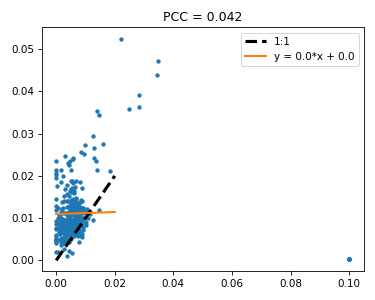

In [266]:
#bad = np.where(abs(cws - 60) < 1) and np.where(np.abs(cws - cws) > 5)[0]
#good = np.where(abs(cws - 60) > 1) and np.where(np.abs(cws - Cws) < 10)[0]
good = np.where(cws<1.02)
#cabs#[cabs>40]

# lrg = linregress(cws, Cws)
lrg = linregress(cws[good], Cws[good])
xx = np.linspace(0, 0.02, 100)
yy = xx*lrg.slope + lrg.intercept


plt.figure(figsize=(5,4), tight_layout=True)
plt.title(f'PCC = {lrg.rvalue:.3f}')
plt.scatter(cws[good], Cws[good], s=10)
# plt.scatter(cws, Cws, s=10)
plt.plot([0,0.02], [0, 0.02], c='k', linewidth=3, linestyle='--', label='1:1')
plt.plot(xx, yy, c='tab:orange', linewidth=2, label=f'y = {lrg.slope:.1f}*x + {lrg.intercept:.1f}')
plt.legend()